Starting simulation: L=50.0, Nx=1001, T_final=100.0, dt=0.05, dx=0.0500
Parameters: A=3.0, B=7.5, Dx=1.0, Dy=10.0
Crank-Nicolson stability condition (unconditionally stable): Ok
Order of accuracy: O(dt^4) for reaction, O(dt^2 + dx^2) for diffusion, O(dt) for splitting
Step: 0/2000, Simulation time: 0.00, Elapsed time: 0.14 sec
  Change in total X (diffusion step): 1.137e-13
  Change in total Y (diffusion step): 1.336e-12
Step: 500/2000, Simulation time: 25.00, Elapsed time: 1.24 sec
  Change in total X (diffusion step): 8.527e-14
  Change in total Y (diffusion step): 1.279e-12
Step: 1000/2000, Simulation time: 50.00, Elapsed time: 2.26 sec
  Change in total X (diffusion step): 1.137e-13
  Change in total Y (diffusion step): 1.236e-12
Step: 1500/2000, Simulation time: 75.00, Elapsed time: 3.37 sec
  Change in total X (diffusion step): 8.527e-14
  Change in total Y (diffusion step): 1.094e-12
Step: 2000/2000, Simulation time: 100.00, Elapsed time: 4.37 sec
  Change in total X (diffusion 

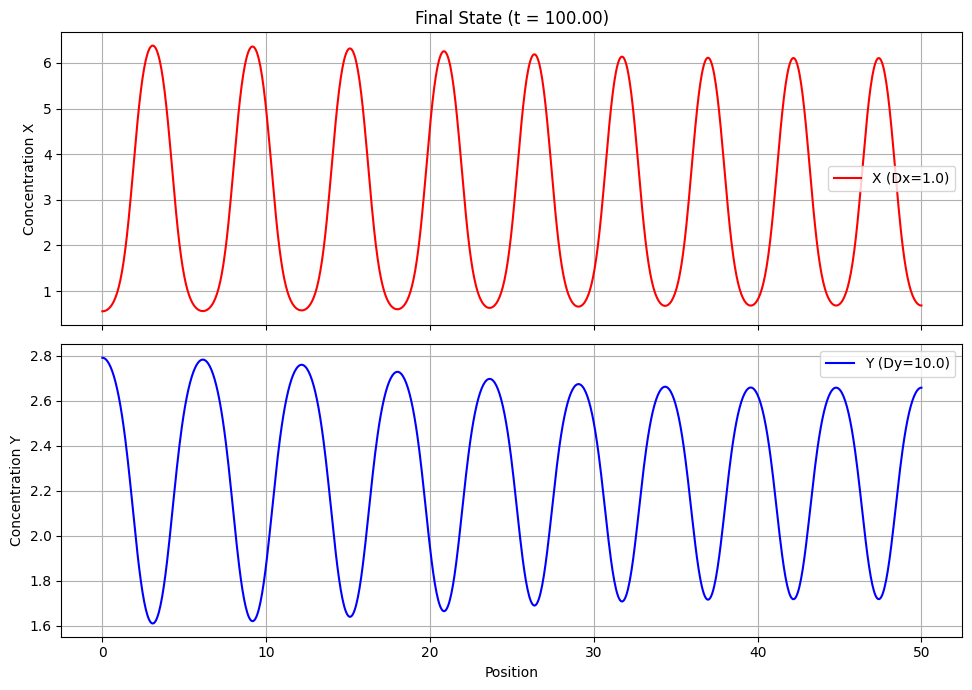

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Model Parameters ---
A = 3.0
B = 7.5
Dx = 1.0
Dy = 10.0

# --- Numerical Solution Parameters ---
L = 50.0  # Domain size (L~1000 may require more time/memory)
Nx = 1001   # Number of grid points (odd number recommended for some BC implementations)
dx = L / (Nx - 1) # Spatial step size
T_final = 100.0 # Final time (may need to be larger for L=1000 or different parameters)
dt = 0.05       # Time step size
N_steps = int(T_final / dt)

# Number of steps between plot updates and checks
plot_interval = 500

# --- Function for solving a tridiagonal system (Thomas Algorithm / TDMA) ---
# Solves A_matrix * z = d_vector, where A_matrix is tridiagonal with diagonals low, diag, up
def solve_tridiagonal(low, diag, up, d):
    n = len(d)
    up_prime = np.zeros(n)
    d_prime = np.zeros(n)

    # Forward elimination pass
    temp_diag_val = diag[0]
    if abs(temp_diag_val) < 1e-15:
         print(f"Error: Division by zero in TDMA (diag[0])")
         return None
    up_prime[0] = up[0] / temp_diag_val
    d_prime[0] = d[0] / temp_diag_val

    for i in range(1, n):
        temp_diag_val = diag[i] - low[i] * up_prime[i-1]
        if abs(temp_diag_val) < 1e-15:
             print(f"Error: Division by zero in TDMA at step {i}")
             return None
        up_prime[i] = up[i] / temp_diag_val
        d_prime[i] = (d[i] - low[i] * d_prime[i-1]) / temp_diag_val

    # Backward substitution pass
    z = np.zeros(n)
    z[n-1] = d_prime[n-1]
    for i in range(n-2, -1, -1):
        z[i] = d_prime[i] - up_prime[i] * z[i+1]
    return z

# --- Initialization ---
pos_grid = np.linspace(0, L, Nx)

# Initial conditions: stationary state + small noise
x = A + 0.01 * (np.random.rand(Nx) - 0.5) # Centered noise
y = B/A + 0.01 * (np.random.rand(Nx) - 0.5) # Centered noise

# --- Main time loop ---
start_time = time.time()
print(f"Starting simulation: L={L}, Nx={Nx}, T_final={T_final}, dt={dt}, dx={dx:.4f}")
print(f"Parameters: A={A}, B={B}, Dx={Dx}, Dy={Dy}")
print(f"Crank-Nicolson stability condition (unconditionally stable): Ok")
print(f"Order of accuracy: O(dt^4) for reaction, O(dt^2 + dx^2) for diffusion, O(dt) for splitting")


# Create a plot window
plt.ion() # Turn on interactive mode for plotting
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
line_x, = ax[0].plot(pos_grid, x, 'r-', label=f'X (Dx={Dx})')
line_y, = ax[1].plot(pos_grid, y, 'b-', label=f'Y (Dy={Dy})')
ax[0].set_ylabel('Concentration X')
ax[0].set_title('Brusselator Simulation (1D)')
ax[0].legend()
ax[0].grid(True)
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Concentration Y')
ax[1].legend()
ax[1].grid(True)
fig.tight_layout() # Adjust plot to prevent labels from overlapping
fig.canvas.draw()
fig.canvas.flush_events()


for step in range(N_steps + 1):
    t = step * dt

    # Save values before the step for conservation checks or debugging
    x_old_step = x.copy() # Using a different name to avoid confusion with x_old for Crank-Nicolson
    y_old_step = y.copy()

    # --- Step 1: Reaction (4th order Runge-Kutta) ---
    def reaction_rhs(x_in, y_in):
        return A - (B + 1) * x_in + x_in**2 * y_in, B * x_in - x_in**2 * y_in

    k1_x, k1_y = reaction_rhs(x, y)
    k2_x, k2_y = reaction_rhs(x + 0.5*dt*k1_x, y + 0.5*dt*k1_y)
    k3_x, k3_y = reaction_rhs(x + 0.5*dt*k2_x, y + 0.5*dt*k2_y)
    k4_x, k4_y = reaction_rhs(x + dt*k3_x, y + dt*k3_y)

    x_star = x + (dt/6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
    y_star = y + (dt/6.0) * (k1_y + 2*k2_y + 2*k3_y + k4_y)

    # --- Step 2: Diffusion (Crank-Nicolson O(dt^2, dx^2) + TDMA) ---

    # Conservation check: Calculate total amount BEFORE diffusion (using trapezoidal rule for integral)
    total_x_before_diffusion = np.sum(x_star) * dx - (0.5 * dx * (x_star[0] + x_star[-1]))
    total_y_before_diffusion = np.sum(y_star) * dx - (0.5 * dx * (y_star[0] + y_star[-1]))

    # Coefficients for the Crank-Nicolson scheme
    alpha_x = 0.5 * Dx * dt / (dx**2)
    alpha_y = 0.5 * Dy * dt / (dx**2)
    
    # --- Solution for X ---
    # Form the right-hand side (RHS) vector for the Crank-Nicolson scheme:
    # RHS_x = (I + 0.5 * dt * Dx * Lap) * x_star ≈ x_star + 0.5 * dt * Dx * Lap(x_old_step) for stability of RHS
    # where Lap(x_old_step) is the discrete Laplacian of x_old_step considering Neumann boundary conditions
    d_x_rhs = np.zeros(Nx)

    # Internal points (i=1 to Nx-2):
    d_x_rhs[1:-1] = x_star[1:-1] + alpha_x * (x_old_step[:-2] + x_old_step[2:] - 2*x_old_step[1:-1])

    # Boundary i=0 (left): Using discrete Neumann BC: (x_1 - x_0)/dx = 0  => x_0 = x_1
    # Lap(x_old_step[0]) * dx^2 ≈ 2*(x_old_step[1] - x_old_step[0]) (ghost point method or one-sided second order)
    d_x_rhs[0] = x_star[0] + 2*alpha_x * (x_old_step[1] - x_old_step[0])

    # Boundary i=Nx-1 (right, index -1): Lap(x_old_step[Nx-1]) * dx^2 ≈ 2*(x_old_step[Nx-2] - x_old_step[Nx-1])
    d_x_rhs[-1] = x_star[-1] + 2*alpha_x * (x_old_step[-2] - x_old_step[-1])

    # Diagonals of the matrix M_x = (I - 0.5 * dt * Dx * Lap) for solving M_x * x_new = d_x_rhs
    # This matrix acts on x_new at the new time step.
    diag_x = np.full(Nx, 1 + 2*alpha_x)
    low_x = np.full(Nx, -alpha_x)
    up_x = np.full(Nx, -alpha_x)
    # Correct the matrix for Neumann boundary conditions (zero-flux)
    # This specific form corresponds to using a ghost point x_{-1} = x_1 and x_{Nx} = x_{Nx-2}
    diag_x[0] = 1 + 2*alpha_x  # Or 1 + alpha_x for simpler one-sided approx.
    up_x[0] = -2*alpha_x     # Or -alpha_x
    low_x[-1] = -2*alpha_x    # Or -alpha_x
    diag_x[-1] = 1 + 2*alpha_x # Or 1 + alpha_x

    x_new = solve_tridiagonal(low_x, diag_x, up_x, d_x_rhs)
    if x_new is None:
        print("Simulation aborted due to error in TDMA for X.")
        break
    
    # --- Solution for Y ---
    # Similarly, form the right-hand side d_y_rhs = (I + 0.5 * dt * Dy * Lap) * y_star
    d_y_rhs = np.zeros(Nx)

    # Internal points:
    d_y_rhs[1:-1] = y_star[1:-1] + alpha_y * (y_old_step[:-2] + y_old_step[2:] - 2*y_old_step[1:-1])
    
    # Boundary i=0:
    d_y_rhs[0] = y_star[0] + 2*alpha_y * (y_old_step[1] - y_old_step[0])
    
    # Boundary i=Nx-1:
    d_y_rhs[-1] = y_star[-1] + 2*alpha_y * (y_old_step[-2] - y_old_step[-1])

    # Diagonals of the matrix M_y = (I - 0.5 * dt * Dy * Lap) for y_new
    diag_y = np.full(Nx, 1 + 2*alpha_y)
    low_y = np.full(Nx, -alpha_y)
    up_y = np.full(Nx, -alpha_y)
    # Correct the matrix for Neumann boundary conditions
    diag_y[0] = 1 + 2*alpha_y
    up_y[0] = -2*alpha_y
    low_y[-1] = -2*alpha_y
    diag_y[-1] = 1 + 2*alpha_y

    y_new = solve_tridiagonal(low_y, diag_y, up_y, d_y_rhs)
    if y_new is None:
        print("Simulation aborted due to error in TDMA for Y.")
        break

    # --- Conservation Check ---
    total_x_after_diffusion = np.sum(x_new) * dx - (0.5 * dx * (x_new[0] + x_new[-1]))
    total_y_after_diffusion = np.sum(y_new) * dx - (0.5 * dx * (y_new[0] + y_new[-1]))
    conservation_err_x = total_x_after_diffusion - total_x_before_diffusion
    conservation_err_y = total_y_after_diffusion - total_y_before_diffusion

    # Update values for the next iteration
    x = x_new
    y = y_new

    # --- Visualization and Information Output (periodically) ---
    if step % plot_interval == 0 or step == N_steps:
        current_run_time = time.time() - start_time
        print(f"Step: {step}/{N_steps}, Simulation time: {t:.2f}, Elapsed time: {current_run_time:.2f} sec")
        # Output conservation error of the diffusion step
        print(f"  Change in total X (diffusion step): {conservation_err_x:.3e}")
        print(f"  Change in total Y (diffusion step): {conservation_err_y:.3e}")

        # Update plot data
        line_x.set_ydata(x)
        line_y.set_ydata(y)
        ax[0].relim() # Recompute the data limits
        ax[0].autoscale_view(scaley=True) # Autoscale Y-axis
        ax[1].relim()
        ax[1].autoscale_view(scaley=True) # Autoscale Y-axis
        ax[0].set_title(f'Brusselator Simulation (1D, t = {t:.2f})')
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Check for NaN or Inf for early stopping
        if not (np.all(np.isfinite(x)) and np.all(np.isfinite(y))):
             print("Error: Non-numerical values (NaN or Inf) detected. Stopping simulation.")
             # Save the last valid data for analysis if needed
             # np.savez('brusselator_error_state.npz', x=x_old_step, y=y_old_step, t=t-dt, pos=pos_grid)
             break

# --- Finalization ---
plt.ioff() # Turn off interactive mode
total_time = time.time() - start_time
print(f"Simulation finished. Total elapsed time: {total_time:.2f} sec.")

# Display final plot
ax[0].set_title(f'Final State (t = {T_final:.2f})')
plt.show()

# Optionally save the final state
# np.savez(f'brusselator_L{L}_T{T_final}_final.npz', x=x, y=y, pos=pos_grid, A=A, B=B, Dx=Dx, Dy=Dy)
# plt.savefig(f'brusselator_L{L}_T{T_final}_final.png')